# Prepare Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as idisplay
import os
import errno
import random
import shutil
import fnmatch
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Input, Concatenate, TimeDistributed, LSTM
from keras_preprocessing.image import ImageDataGenerator
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

from google.colab import files
from google.colab import drive

from pathlib import Path

In [2]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

Mounted at /content/gdrive


# GPU Utilization

In [ ]:
print("GPU Name: ", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU Name:  /device:GPU:0
Num GPUs Available:  1


# Transform Function
1. Get every audio by filename
2. Take the label from txt file
3. Convert Audio into Image
4. Iterate for 5 sessions

In [3]:
def getLabel(path, name):
  label_file = open(path, 'r')
  label_lines = label_file.readlines()

  line = [line for line in label_lines if name in line]
  line = line[0].replace(";", ":")
  label = line.split(":")[1]

  return label

def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def saveImage(path_audio, path_output, audio_name, label):
  audio_file, sample_rate = librosa.load(path_audio + audio_name + '.wav', mono=True)
  S = librosa.feature.mfcc(y=audio_file, sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  
  filename = path_output + label + "/" + audio_name + '.png'
  checkAndCreateDirectory(filename)

  plt.gca().set_axis_off()
  plt.savefig(filename, dpi=100, bbox_inches='tight',pad_inches=0)
  # plt.show()
  plt.clf()
  plt.close('all')

def readAudioList(path_label, path_audio, path_output, recording, audio_list):
  print("Progress.. Audio ")

  for audio_name in audio_list:
    print(audio_name[-4:], end=' ')
    recordings = [file.name for file in os.scandir(path_audio)]
    
    label_file = [file.name for file in os.scandir(path_label) if recording in file.name]
    label_file = [filename for filename in label_file if '.txt' in filename][0]
    label_title = getLabel(path_label + label_file, audio_name)

    saveImage(path_audio, path_output, audio_name, label_title)

def deleteExtensions(audio_name):
  return audio_name.replace(".wav", "")

def transformAllSessions():
  sessions = ["1", "2", "3", "4", "5"]

  for session in sessions:
    print("\nProgress.. Session " + session)

    path_output = '/content/test/Session' + session + '/categorical/'
    path_audio = iemocap + '/Session' + session + '/sentences/wav/'
    path_label = iemocap + '/Session' + session + '/dialog/EmoEvaluation/Categorical/'

    recordings = [file.name for file in os.scandir(path_audio)]
    recordings.sort()

    for recording in recordings:
      print("\n\nProgress.. Recording " + recording + "\n")

      path_audio = iemocap + '/Session' + session + '/sentences/wav/'
      path_audio = path_audio + recording + "/"

      audio_list = [file.name for file in os.scandir(path_audio) if ".pk" not in file.name]
      audio_list = list(map(deleteExtensions, audio_list))
      audio_list.sort()
      
      readAudioList(path_label, path_audio, path_output, recording, audio_list)

def downloadLocalData():
  !zip -r /content/test.zip /content/test
  files.download("/content/test.zip")

def clearLocalFolder():
  !ls test
  !rm -rf test
  !rm test.zip

# clearLocalFolder()
# transformAllSessions()
# downloadLocalData()

# Retrieve data
Classification, 998 images of:
- Neutral state
- Happiness
- Anger
- Sadness

In [5]:
def clearData():
  !rm -rf "mfcc/train"
  !rm -rf "mfcc/test"
  !rm -rf "spectogram/test"
  !rm -rf "spectogram/test"

def splitData(path, category, filenames, feature):
  sourcePath = path + feature + "/" + category
  splitPercentage = int((len(filenames)+1) * .80)
  
  trainPath = feature + "/train/" + category
  trainData = filenames[:splitPercentage]

  for trainFile in trainData:
    checkAndCreateDirectory(trainPath + "/" + trainFile)
    shutil.copyfile(sourcePath + "/" + trainFile, trainPath + "/" + trainFile)

  testPath = feature + "/test/" + category
  testData = filenames[splitPercentage:]
  checkAndCreateDirectory(testPath)

  for testFile in testData:
    checkAndCreateDirectory(testPath + "/" + testFile)
    shutil.copyfile(sourcePath + "/" + testFile, testPath + "/" + testFile)

def getRandomData(feature):
  dataset = iemocap + "/Images/"
  categories = ["Neutral state", "Happiness", "Anger", "Sadness"]

  for category in categories:
    path = dataset + feature + "/" + category
    filenames = random.sample(os.listdir(path), 998)
    splitData(dataset, category, filenames, feature)

def exportDataset():
  !zip -r mfcc/mfcc.zip mfcc
  shutil.copyfile("mfcc/mfcc.zip", iemocap + "/Images/export/mfcc.zip")

  !zip -r spectogram/spectogram.zip spectogram
  shutil.copyfile("spectogram/spectogram.zip", iemocap + "/Images/export/spectogram.zip")

def importDataset():
  # shutil.copyfile(iemocap + "/Images/export/mfcc.zip", "mfcc.zip")
  # !unzip mfcc.zip

  shutil.copyfile(iemocap + "/Images/export/spectogram.zip", "spectogram.zip")
  !unzip spectogram.zip

# clearData()

# getRandomData("mfcc")
# getRandomData("spectogram")

# exportDataset()
# importDataset()

# Preprocess

In [6]:
def save_model(model, filename):
  checkAndCreateDirectory("model/test.txt")
  with open("model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def load_model(struct, weight):
  json_file = open("model/" + struct + ".json", "r")
  loaded_model_json = json_file.read()
  json_file.close()

  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("model/" + weight + ".hdf5")
  loaded_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return loaded_model

# def load_data_mfcc():
#   data_generator = ImageDataGenerator(validation_split=0.3)
#   train_data = data_generator.flow_from_directory(
#       directory="mfcc/train/",
#       class_mode="categorical",
#       subset="training",
#       batch_size=1,
#       shuffle=True,
#       target_size=(256, 256)
#   )

#   x_train = []
#   y_train = []

#   for i in range(train_data.__len__()):
#     a, b = train_data.next()
#     x_train.append(a[0])
#     y_train.append(b[0])

#   x_train = np.array(x_train)
#   y_train = np.array(y_train)

#   validation_data = data_generator.flow_from_directory(
#       directory="mfcc/train/",
#       class_mode="categorical",
#       subset="validation",
#       batch_size=1,
#       shuffle=True,
#       target_size=(256, 256)
#   )

#   x_val = []
#   y_val = []

#   for i in range(validation_data.__len__()):
#     a, b = validation_data.next()
#     x_val.append(a[0])
#     y_val.append(b[0])

#   x_val = np.array(x_val)
#   y_val = np.array(y_val)

#   return x_train, y_train, x_val, y_val

def load_data_spectogram():
  data_generator = ImageDataGenerator(validation_split=0.3)
  train_data = data_generator.flow_from_directory(
      directory="spectogram/train/",
      class_mode="categorical",
      subset="training",
      batch_size=1,
      shuffle=True,
      target_size=(256, 256)
  )
    
  x_train = []
  y_train = []

  for i in range(train_data.__len__()):
    a, b = train_data.next()
    x_train.append(a[0])
    y_train.append(b[0])

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  validation_data = data_generator.flow_from_directory(
      directory="spectogram/train/",
      class_mode="categorical",
      subset="validation",
      batch_size=1,
      shuffle=True,
      target_size=(256, 256)
  )

  x_val = []
  y_val = []

  for i in range(validation_data.__len__()):
    a, b = validation_data.next()
    x_val.append(a[0])
    y_val.append(b[0])

  x_val = np.array(x_val)
  y_val = np.array(y_val)

  return x_train, y_train, x_val, y_val

# mfcc_x_train, mfcc_y_train, mfcc_x_val, mfcc_y_val = load_data_mfcc()
spectogram_x_train, spectogram_y_train, spectogram_x_val, spectogram_y_val = load_data_spectogram()

Found 2240 images belonging to 4 classes.
Found 956 images belonging to 4 classes.


# Model

Model is builded
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 84, 84, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 82, 82, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 25, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8

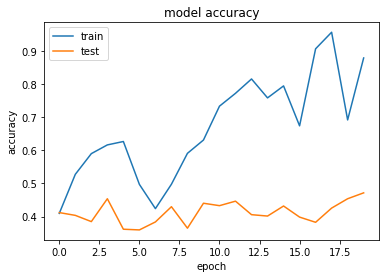

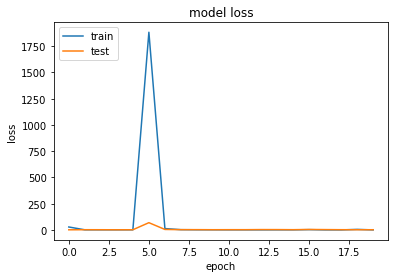

Model is weight_model_0_20_0.33_0.88_1.86_0.47
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.45397, saving model to /content/model/weight_model_1_01_6.15_0.66_2.27_0.45.hdf5
448/448 - 10s - loss: 6.1483 - accuracy: 0.6616 - val_loss: 2.2667 - val_accuracy: 0.4540
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.45397
448/448 - 10s - loss: 1.1086 - accuracy: 0.6839 - val_loss: 2.5628 - val_accuracy: 0.4320
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.45397
448/448 - 10s - loss: 253.6035 - accuracy: 0.4719 - val_loss: 2.6655 - val_accuracy: 0.4111
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.45397 to 0.46444, saving model to /content/model/weight_model_1_04_1.21_0.57_1.44_0.46.hdf5
448/448 - 10s - loss: 1.2093 - accuracy: 0.5692 - val_loss: 1.4363 - val_accuracy: 0.4644
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.46444
448/448 - 10s - loss: 0.7260 - accuracy: 0.7116 - val_loss: 1.5463 - val_accuracy: 0.4592
Epoch 6/20


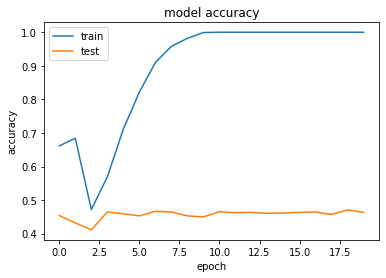

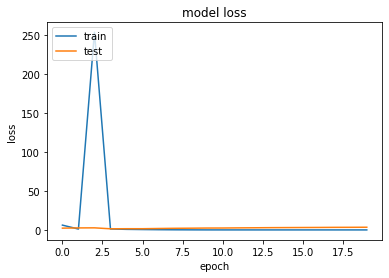

Model is weight_model_1_19_0.00_1.00_3.34_0.47
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.46444, saving model to /content/model/weight_model_2_01_5.29_0.77_2.15_0.46.hdf5
448/448 - 10s - loss: 5.2855 - accuracy: 0.7723 - val_loss: 2.1509 - val_accuracy: 0.4644
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.46444
448/448 - 10s - loss: 0.5607 - accuracy: 0.8621 - val_loss: 2.7811 - val_accuracy: 0.4603
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.46444
448/448 - 10s - loss: 1.6054 - accuracy: 0.6830 - val_loss: 2.4298 - val_accuracy: 0.4289
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.46444
448/448 - 10s - loss: 0.5429 - accuracy: 0.8460 - val_loss: 3.4274 - val_accuracy: 0.3797
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.46444
448/448 - 10s - loss: 334.6768 - accuracy: 0.4295 - val_loss: 1.7647 - val_accuracy: 0.4561
Epoch 6/20

Epoch 00006: val_accuracy did not improve from 0.46444
448/448 - 10s - loss: 0

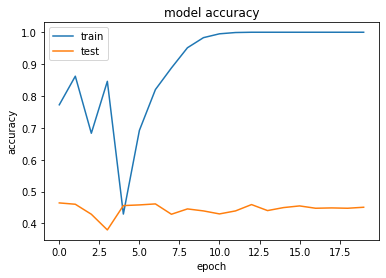

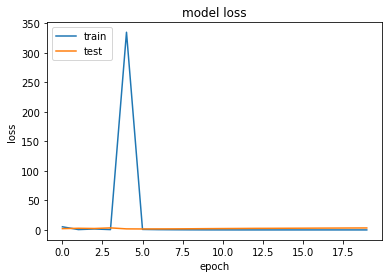

Model is weight_model_2_01_5.29_0.77_2.15_0.46
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.31590, saving model to /content/model/weight_model_3_01_2.35_0.74_4.07_0.32.hdf5
448/448 - 10s - loss: 2.3483 - accuracy: 0.7442 - val_loss: 4.0682 - val_accuracy: 0.3159
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.31590 to 0.45293, saving model to /content/model/weight_model_3_02_49.53_0.52_1.30_0.45.hdf5
448/448 - 10s - loss: 49.5314 - accuracy: 0.5192 - val_loss: 1.3032 - val_accuracy: 0.4529
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.45293
448/448 - 10s - loss: 0.5597 - accuracy: 0.7946 - val_loss: 1.5572 - val_accuracy: 0.4362
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.45293
448/448 - 10s - loss: 0.2467 - accuracy: 0.9201 - val_loss: 1.8737 - val_accuracy: 0.4404
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.45293
448/448 - 10s - loss: 0.0823 - accuracy: 0.9821 - val_loss: 2.3122 - val_accuracy: 0.4425
Epoch 6/20


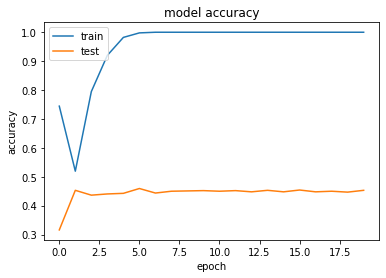

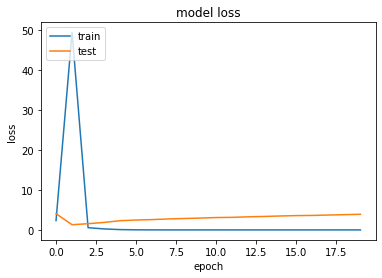

Model is weight_model_3_06_0.02_1.00_2.48_0.46
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.43410, saving model to /content/model/weight_model_4_01_2.24_0.81_3.18_0.43.hdf5
448/448 - 10s - loss: 2.2375 - accuracy: 0.8085 - val_loss: 3.1765 - val_accuracy: 0.4341
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.43410
448/448 - 10s - loss: 0.4963 - accuracy: 0.8442 - val_loss: 2.6846 - val_accuracy: 0.4142
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.43410
448/448 - 10s - loss: 208.3342 - accuracy: 0.5625 - val_loss: 3.1204 - val_accuracy: 0.4090
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.43410
448/448 - 10s - loss: 0.6698 - accuracy: 0.7598 - val_loss: 1.9148 - val_accuracy: 0.4100
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.43410 to 0.44247, saving model to /content/model/weight_model_4_05_0.26_0.91_2.01_0.44.hdf5
448/448 - 10s - loss: 0.2566 - accuracy: 0.9098 - val_loss: 2.0054 - val_accuracy: 0.4425
Epoch 6/20


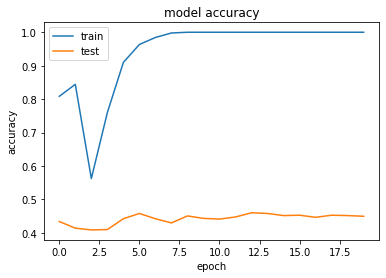

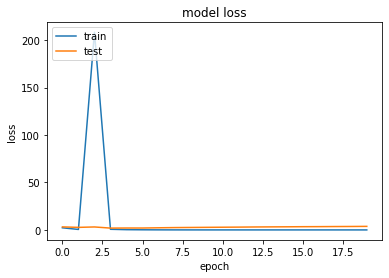

Model is weight_model_4_13_0.00_1.00_3.10_0.46
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.44247, saving model to /content/model/weight_model_5_01_2.82_0.86_2.94_0.44.hdf5
448/448 - 10s - loss: 2.8164 - accuracy: 0.8594 - val_loss: 2.9391 - val_accuracy: 0.4425
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.44247 to 0.45502, saving model to /content/model/weight_model_5_02_0.21_0.94_4.36_0.46.hdf5
448/448 - 10s - loss: 0.2134 - accuracy: 0.9438 - val_loss: 4.3624 - val_accuracy: 0.4550
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.45502 to 0.45711, saving model to /content/model/weight_model_5_03_55.99_0.64_1.67_0.46.hdf5
448/448 - 10s - loss: 55.9869 - accuracy: 0.6379 - val_loss: 1.6746 - val_accuracy: 0.4571
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.45711
448/448 - 10s - loss: 0.1581 - accuracy: 0.9527 - val_loss: 1.9924 - val_accuracy: 0.4477
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.45711
448/448 - 10s - loss: 

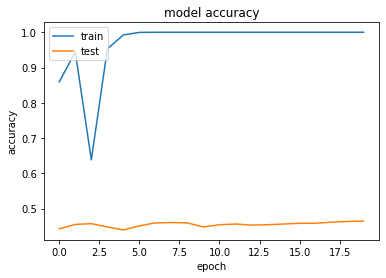

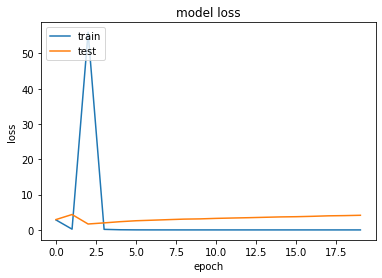

Model is weight_model_5_20_0.00_1.00_4.15_0.46
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.35565, saving model to /content/model/weight_model_6_01_1.81_0.82_10.24_0.36.hdf5
448/448 - 10s - loss: 1.8083 - accuracy: 0.8210 - val_loss: 10.2398 - val_accuracy: 0.3556
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.35565 to 0.41736, saving model to /content/model/weight_model_6_02_1.37_0.79_3.34_0.42.hdf5
448/448 - 10s - loss: 1.3700 - accuracy: 0.7915 - val_loss: 3.3434 - val_accuracy: 0.4174
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.41736
448/448 - 10s - loss: 0.5484 - accuracy: 0.9103 - val_loss: 7.1614 - val_accuracy: 0.3452
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.41736
448/448 - 10s - loss: 538.3055 - accuracy: 0.4844 - val_loss: 4.8623 - val_accuracy: 0.3452
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.41736
448/448 - 10s - loss: 0.7718 - accuracy: 0.7946 - val_loss: 3.1921 - val_accuracy: 0.4132
Epoch 6/2

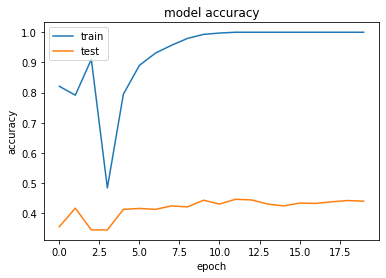

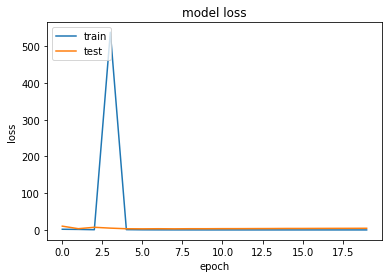

Model is weight_model_6_12_0.01_1.00_3.51_0.45
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.45293, saving model to /content/model/weight_model_7_01_3.58_0.87_3.57_0.45.hdf5
448/448 - 10s - loss: 3.5756 - accuracy: 0.8679 - val_loss: 3.5702 - val_accuracy: 0.4529
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.45293 to 0.46130, saving model to /content/model/weight_model_7_02_0.61_0.91_7.09_0.46.hdf5
448/448 - 10s - loss: 0.6141 - accuracy: 0.9147 - val_loss: 7.0865 - val_accuracy: 0.4613
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.46130 to 0.46653, saving model to /content/model/weight_model_7_03_1.06_0.85_4.36_0.47.hdf5
448/448 - 10s - loss: 1.0625 - accuracy: 0.8522 - val_loss: 4.3647 - val_accuracy: 0.4665
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.46653
448/448 - 10s - loss: 0.2189 - accuracy: 0.9469 - val_loss: 4.6897 - val_accuracy: 0.4372
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.46653
448/448 - 10s - loss: 10

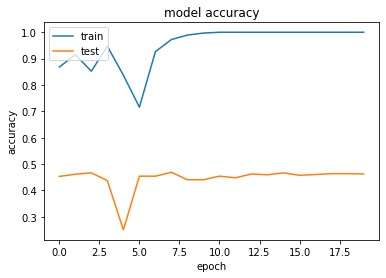

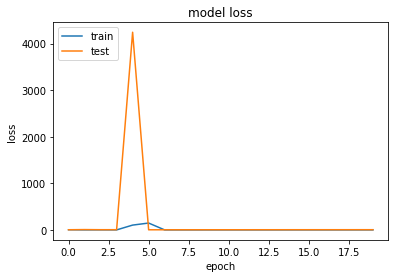

Model is weight_model_7_08_0.09_0.97_3.05_0.47
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.37971, saving model to /content/model/weight_model_8_01_2.18_0.87_6.41_0.38.hdf5
448/448 - 10s - loss: 2.1834 - accuracy: 0.8652 - val_loss: 6.4112 - val_accuracy: 0.3797
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.37971 to 0.38075, saving model to /content/model/weight_model_8_02_2.75_0.79_8.57_0.38.hdf5
448/448 - 10s - loss: 2.7486 - accuracy: 0.7871 - val_loss: 8.5723 - val_accuracy: 0.3808
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.38075 to 0.40272, saving model to /content/model/weight_model_8_03_0.97_0.87_6.66_0.40.hdf5
448/448 - 10s - loss: 0.9657 - accuracy: 0.8665 - val_loss: 6.6567 - val_accuracy: 0.4027
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.40272 to 0.41318, saving model to /content/model/weight_model_8_04_0.17_0.96_5.40_0.41.hdf5
448/448 - 10s - loss: 0.1730 - accuracy: 0.9603 - val_loss: 5.3956 - val_accuracy: 0.4132
Epoch 5/20



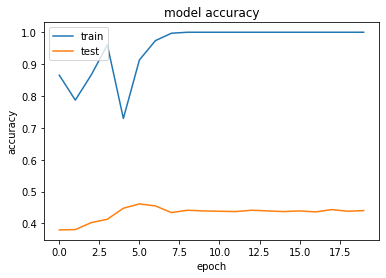

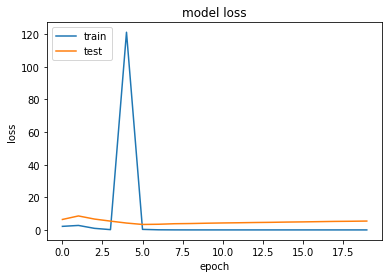

Model is weight_model_8_06_0.33_0.91_3.35_0.46
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.42782, saving model to /content/model/weight_model_9_01_1.97_0.85_7.78_0.43.hdf5
448/448 - 10s - loss: 1.9732 - accuracy: 0.8482 - val_loss: 7.7802 - val_accuracy: 0.4278
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.42782
448/448 - 10s - loss: 3.1398 - accuracy: 0.7768 - val_loss: 9.3990 - val_accuracy: 0.3944
Epoch 3/20

Epoch 00003: val_accuracy did not improve from 0.42782
448/448 - 10s - loss: 0.3619 - accuracy: 0.9451 - val_loss: 6.3761 - val_accuracy: 0.4027
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.42782
448/448 - 10s - loss: 0.1667 - accuracy: 0.9652 - val_loss: 10.9319 - val_accuracy: 0.3975
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.42782 to 0.44456, saving model to /content/model/weight_model_9_05_235.71_0.73_13.52_0.44.hdf5
448/448 - 10s - loss: 235.7075 - accuracy: 0.7263 - val_loss: 13.5242 - val_accuracy: 0.4446
Epoch 

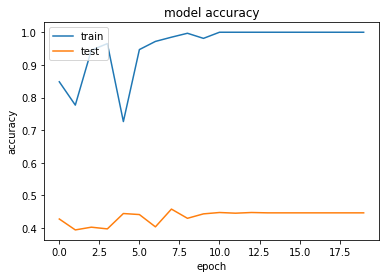

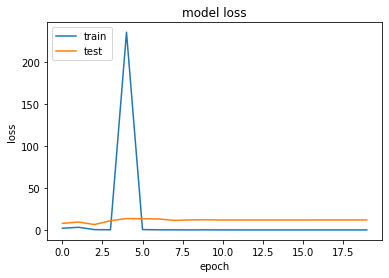

In [11]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def build_convolution(model):
  model = Conv2D(128, 3)(model)
  model = MaxPooling2D(pool_size=(3, 3))(model)

  model = Conv2D(128, 3)(model)
  model = MaxPooling2D(pool_size=(3, 3))(model)

  model = Conv2D(128, 3)(model)
  model = MaxPooling2D(pool_size=(3, 3))(model)

  # model = Conv2D(256, 3)(model)
  # model = MaxPooling2D(pool_size=(3, 3))(model)

  return model

def build_model():

  # mfcc_input = Input(shape=(256, 256, 3))
  # mfcc_model = build_convolution(mfcc_input)

  spectogram_input = Input(shape=(256, 256, 3))
  spectogram_model = build_convolution(spectogram_input)

  # result_model = Sequential()
  # eff = tf.keras.applications.EfficientNetB5(
  #     weights=None,
  #     input_shape=(256,256,3)
  # )
  
  # result_model.add(eff)
  # result_model.add(Flatten())
  # result_model.add(Dense(4, activation='softmax'))

  # result_model = Concatenate()([mfcc_model])
  result_model = Flatten()(spectogram_model)

  result_model = Dense(128)(result_model)
  result_model = Dense(128)(result_model)
  result_model = Dense(128)(result_model)
  # result_model = Dropout(0.2)(result_model)

  # result_model = Dense(256)(result_model)
  # result_model = Dense(256)(result_model)
  # result_model = Dense(256)(result_model)
  # result_model = Dropout(0.2)(result_model)

  result_model = Dense(4, activation='softmax')(result_model)

  result_model = Model(inputs=[spectogram_input], outputs=[result_model])
  result_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  save_model(result_model, "struct_model")
  result_model.summary()
  plot_model(result_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  return result_model

def get_model():
  if os.path.isfile("/content/model/struct_model.json"):
    lastCheckpoint = sorted(Path("/content/model").iterdir(), key=os.path.getmtime)[-1].stem
    print("Model is " + lastCheckpoint)

    model = load_model("struct_model", lastCheckpoint)
    return model
  else:
    print("Model is builded")
    return build_model()

def train_model():
  checkAndCreateDirectory("/content/model/test.txt")

  for iteration in range(10):
    basepath = '/content/model/weight_model_' + str(iteration)
    best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
    callback_list = [best_checkpoint]

    model = get_model()
    history = model.fit(
        [spectogram_x_train],
        spectogram_y_train,
        batch_size=5,
        validation_data=([spectogram_x_val], spectogram_y_val),
        epochs=20,
        callbacks=callback_list,
        verbose=2
    )

    plot_result(model, history)

  return model, history

!rm -rf /content/model
model, history = train_model()

# Evaluation

In [12]:
test_generator = ImageDataGenerator()
test_data = test_generator.flow_from_directory(
    directory="spectogram/test/",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    target_size=(256, 256)
)

loss, accuracy = model.evaluate_generator(generator=test_data)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

Found 796 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
Prediction Loss: 10
Prediction Accuracy: 46%


# Analysis

In [13]:
target_names = ['Angry', 'Happy', 'Neutral', "Sad"]

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

print('\n\nClassification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[109  38  36  16]
 [ 31  84  44  40]
 [ 16  58  73  52]
 [ 19  35  38 107]]


Classification Report
              precision    recall  f1-score   support

       Angry       0.62      0.55      0.58       199
       Happy       0.39      0.42      0.41       199
     Neutral       0.38      0.37      0.37       199
         Sad       0.50      0.54      0.52       199

    accuracy                           0.47       796
   macro avg       0.47      0.47      0.47       796
weighted avg       0.47      0.47      0.47       796

